In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from champion_map_zh2en import translate_champion, translate_dataframe


# df1 = pd.read_csv("./data/16_teams.csv")
# df2 = pd.read_csv("./data/24world_teams_processed.csv")


# matches = pd.concat([df1, df2], ignore_index=True)
matches = pd.read_csv("./data/2021_worlds_kda_with_result.csv")
file = "./data/pro_player_champion_stats.xlsx"

# Sheet names (match the Excel sheets)
positions = ["上单 (Total Picks 1296)",
             "打野 (Total Picks 1160)",
             "中单 (Total Picks 877)",
             "ADC (Total Picks 1074)",
             "辅助 (Total Picks 830)"]

# Assign positions to each team's players in pick order
matches['position'] = matches.groupby(['gameid', 'team']).cumcount().map(lambda x: positions[x])

# Read all sheets and translate champion names to English
pos_data = {}
for sheet in positions:
    df = pd.read_excel(file, sheet_name=sheet)
    df = translate_dataframe(df, 'champion')
    df.columns = df.columns.str.strip()
    df = df[['champion', 'Picks', 'Pick Rate (%)', 'Win Rate (%)']].copy()
    df['Pick Rate (%)'] = df['Pick Rate (%)'].str.rstrip('%').astype(float) / 100
    df['Win Rate (%)'] = df['Win Rate (%)'].str.rstrip('%').astype(float) / 100
    pos_data[sheet] = df.set_index('champion').to_dict('index')

# Map global champion stats by position
def get_global_stat(champ, position, key):
    try:
        return pos_data[position][champ][key]
    except KeyError:
        return None

matches['global_pickrate'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Pick Rate (%)'), axis=1)
matches['global_winrate'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Win Rate (%)'), axis=1)
matches['global_picks'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Picks'), axis=1)

# Aggregate to the team level
team_stats = matches.groupby(['gameid', 'team', 'win_loss']).agg(
    avg_global_pickrate=('global_pickrate','mean'),
    avg_global_winrate=('global_winrate','mean'),
    avg_global_picks=('global_picks','mean')
).reset_index()

# Merge the two teams and compute differences
games = team_stats.merge(team_stats, on='gameid', suffixes=('_A','_B'))
games = games[games['win_loss_A'] != games['win_loss_B']]
games['pickrate_diff'] = games['avg_global_pickrate_A'] - games['avg_global_pickrate_B']
games['winrate_diff'] = games['avg_global_winrate_A'] - games['avg_global_winrate_B']
games['picks_diff'] = games['avg_global_picks_A'] - games['avg_global_picks_B']
games['A_win'] = (games['win_loss_A'] == 'Win').astype(int)


3 feature 'winrate_diff','pickrate_diff','picks_diff'

In [ ]:
import xgboost as xgb

#  Check label distribution
print("A_win value counts:")
print(games['A_win'].value_counts())


# Features and label
X = games[['winrate_diff','pickrate_diff','picks_diff']]
y = games['A_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train Random Forest (balance classes via class_weight)
rf_model = RandomForestClassifier(n_estimators=1000, random_state=5101, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("RandomForest Accuracy:", round(accuracy_score(y_test, y_pred_rf),3))
print("RandomForest F1 Score:", round(f1_score(y_test, y_pred_rf),3))

# Train XGBoost (optional)
# Compute negative/positive class ratio
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False,
                              eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", round(accuracy_score(y_test, y_pred_xgb),3))
print("XGBoost F1 Score:", round(f1_score(y_test, y_pred_xgb),3))

A_win value counts:
A_win
0    121
1    121
Name: count, dtype: int64
RandomForest Accuracy: 0.59
RandomForest F1 Score: 0.615


/opt/miniconda3/envs/py310/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [22:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.639
XGBoost F1 Score: 0.667


5 feature RandomForest

In [ ]:

# Load data
# matches = pd.read_csv("./data/16_teams.csv")
solo = pd.read_csv("./data/solo_stats.csv")  # Player solo queue winrate/pickrate/games
file = "./data/pro_player_champion_stats.xlsx"

positions = ["上单 (Total Picks 1296)",
             "打野 (Total Picks 1160)",
             "中单 (Total Picks 877)",
             "ADC (Total Picks 1074)",
             "辅助 (Total Picks 830)"]

# Assign position to each player in order within a team
# matches['position'] = matches.groupby(['gameid','team']).cumcount().map(lambda x: positions[x])


pos_data = {}
for sheet in positions:
    df = pd.read_excel(file, sheet_name=sheet)
    df = translate_dataframe(df, 'champion')
    df.columns = df.columns.str.strip()
    df = df[['champion','Picks','Pick Rate (%)','Win Rate (%)']].copy()
    df['Pick Rate (%)'] = df['Pick Rate (%)'].str.rstrip('%').astype(float)/100
    df['Win Rate (%)'] = df['Win Rate (%)'].str.rstrip('%').astype(float)/100
    pos_data[sheet] = df.set_index('champion').to_dict('index')

# Match global champion features
def get_global_stat(champ, position, key):
    try:
        return pos_data[position][champ][key]
    except KeyError:
        return np.nan

matches['global_pickrate'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Pick Rate (%)'), axis=1)
matches['global_winrate'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Win Rate (%)'), axis=1)
matches['global_picks'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Picks'), axis=1)

solo_dict = solo.set_index(['player','champion']).to_dict('index')

def get_solo_stat(player, champ, key):
    try:
        return solo_dict[(player, champ)][key]
    except KeyError:
        return np.nan

matches['solo_pickrate'] = matches.apply(lambda x: get_solo_stat(x['player'], x['champion'], 'pickrate'), axis=1)
matches['solo_winrate'] = matches.apply(lambda x: get_solo_stat(x['player'], x['champion'], 'winrate'), axis=1)


# Aggregate to team level (mean)
team_stats = matches.groupby(['gameid','team','win_loss']).agg(
    avg_global_pickrate=('global_pickrate','mean'),
    avg_global_winrate=('global_winrate','mean'),
    avg_global_picks=('global_picks','mean'),
    avg_solo_pickrate=('solo_pickrate','mean'),
    avg_solo_winrate=('solo_winrate','mean')
).reset_index()

# 
games = team_stats.merge(team_stats, on='gameid', suffixes=('_A','_B'))
games = games[games['win_loss_A'] != games['win_loss_B']]
games['pickrate_diff'] = games['avg_global_pickrate_A'] - games['avg_global_pickrate_B']
games['winrate_diff'] = games['avg_global_winrate_A'] - games['avg_global_winrate_B']
games['picks_diff'] = games['avg_global_picks_A'] - games['avg_global_picks_B']
games['solo_pickrate_diff'] = games['avg_solo_pickrate_A'] - games['avg_solo_pickrate_B']
games['solo_winrate_diff'] = games['avg_solo_winrate_A'] - games['avg_solo_winrate_B']

games['A_win'] = (games['win_loss_A']=='Win').astype(int)

# Modeling
features = ['pickrate_diff','winrate_diff','picks_diff','solo_pickrate_diff','solo_winrate_diff']
X = games[features]
y = games['A_win']

# Fill NaNs with 0
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=1500, random_state=5101, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test,y_pred),3))
print("F1 Score:", round(f1_score(y_test,y_pred),3))

# Feature importance
importances = pd.Series(model.feature_importances_, index=features)
print("\nFeature Importance:")
print(importances.sort_values(ascending=False))

Accuracy: 0.607
F1 Score: 0.625

Feature Importance:
pickrate_diff         0.250407
picks_diff            0.240469
winrate_diff          0.202961
solo_pickrate_diff    0.164484
solo_winrate_diff     0.141679
dtype: float64


 ## XGB

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

# Assume matches and games have already generated difference features
features = ['pickrate_diff','winrate_diff','picks_diff','solo_pickrate_diff','solo_winrate_diff']
X = games[features]
y = games['A_win']

# Fill NaNs with 0
X = X.fillna(0)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute class ratio for scale_pos_weight
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=5101
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", round(accuracy_score(y_test, y_pred),3))
print("XGBoost F1 Score:", round(f1_score(y_test, y_pred),3))

importances = pd.Series(xgb_model.feature_importances_, index=features)
print("\nFeature Importance:")
print(importances.sort_values(ascending=False))


/opt/miniconda3/envs/py310/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [22:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.705
XGBoost F1 Score: 0.719

Feature Importance:
solo_pickrate_diff    0.425828
solo_winrate_diff     0.186309
picks_diff            0.138591
pickrate_diff         0.131954
winrate_diff          0.117317
dtype: float32


# Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# Define model
rf_model = RandomForestClassifier(
    n_estimators=1000,
    random_state=5101,
    class_weight='balanced'
)

# 10-fold stratified CV (preserves class balance per fold)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5102)

# Multiple evaluation metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

# Run cross validation
cv_results = cross_validate(rf_model, X, y, cv=cv, scoring=scoring)

# Output metrics
print("RandomForest 10-Fold Accuracy:", round(cv_results['test_accuracy'].mean(), 3))
print("RandomForest 10-Fold F1 Score:", round(cv_results['test_f1'].mean(), 3))

RandomForest 10-Fold Accuracy: 0.628
RandomForest 10-Fold F1 Score: 0.628


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import xgboost as xgb

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    # use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=5101
)

# 10-fold stratified CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5102)

# Multiple evaluation metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

# Run cross validation
cv_results = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)

# Output metrics
print("XGBoost 10-Fold Accuracy:", round(cv_results['test_accuracy'].mean(), 3))
print("XGBoost 10-Fold F1 Score:", round(cv_results['test_f1'].mean(), 3))

XGBoost 10-Fold Accuracy: 0.62
XGBoost 10-Fold F1 Score: 0.607


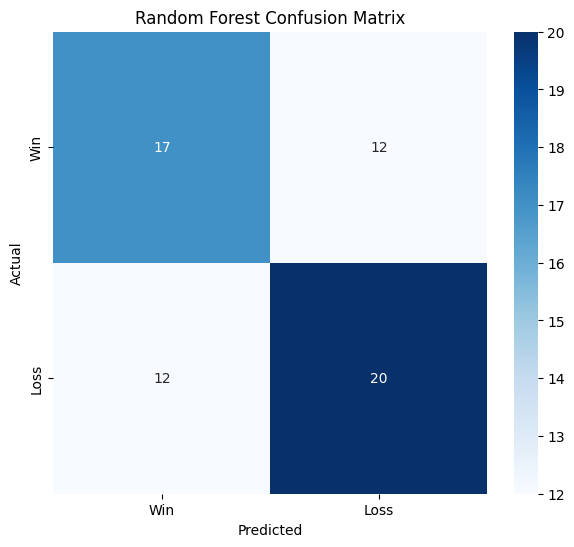

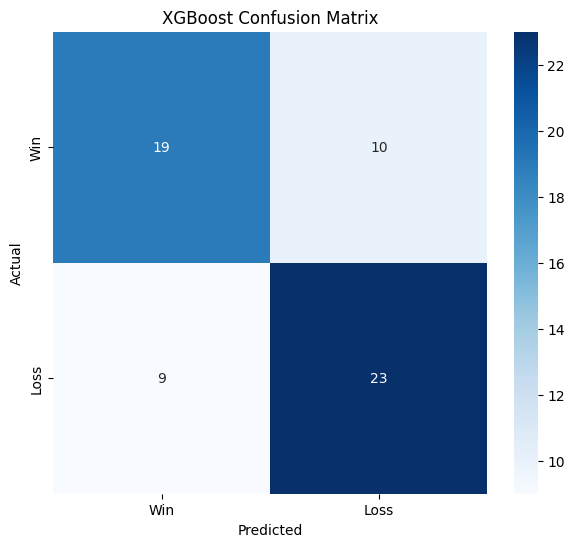

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Random Forest predictions
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# XGBoost predictions
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Compute confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot Random Forest confusion matrix heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Win', 'Loss'], yticklabels=['Win', 'Loss'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot XGBoost confusion matrix heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Win', 'Loss'], yticklabels=['Win', 'Loss'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Import logistic regression and related utilities
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Logistic Regression ---

# 1. Initialize and train
# Logistic regression is a suitable linear model for classification
# Increase max_iter to ensure convergence
log_reg_model = LogisticRegression(random_state=5101, max_iter=2000)
log_reg_model.fit(X_train, y_train)

# 2. Predict on the test set
y_pred_lr = log_reg_model.predict(X_test)

# 3. Evaluate performance
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"逻辑回归模型准确率: {accuracy_lr:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred_lr, target_names=['Loss', 'Win']))

# 4. Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Greens",
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 5. 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5102)
cv_scores_lr = cross_val_score(log_reg_model, X, y, cv=cv, scoring='accuracy')

print(f"\n逻辑回归 10折交叉验证平均准确率: {np.mean(cv_scores_lr):.4f}")
print("每折准确率:", cv_scores_lr)

支持向量机 (SVM) 模型准确率: 0.5410

分类报告:
              precision    recall  f1-score   support

        Loss       0.52      0.55      0.53        29
         Win       0.57      0.53      0.55        32

    accuracy                           0.54        61
   macro avg       0.54      0.54      0.54        61
weighted avg       0.54      0.54      0.54        61



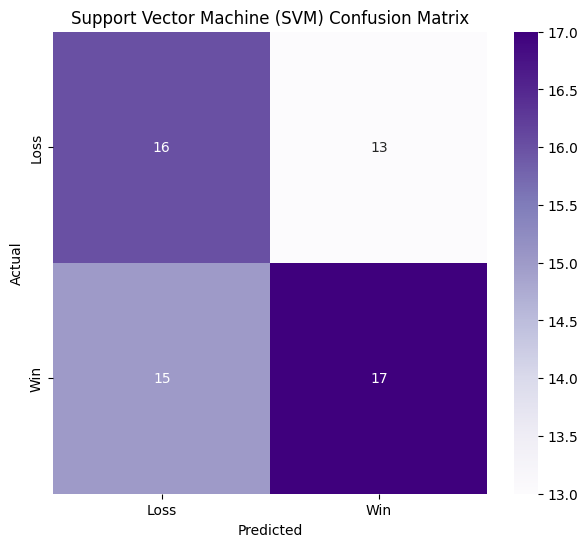


SVM 10折交叉验证平均准确率: 0.5743
每折准确率: [0.64       0.52       0.70833333 0.58333333 0.625      0.45833333
 0.45833333 0.66666667 0.625      0.45833333]


In [ ]:
# Import SVM and related tools
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Support Vector Machine (SVM) ---

# 1. Create a pipeline with standardization and SVM
#    Ensures data is scaled properly during both training and prediction
#    'C' controls regularization; 'gamma' and 'kernel' are key SVM hyperparameters
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=5101, probability=True)
)

# 2. Fit the pipeline on the training set
svm_pipeline.fit(X_train, y_train)

# 3. Predict on the test set
y_pred_svm = svm_pipeline.predict(X_test)

# 4. Evaluate performance
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"支持向量机 (SVM) 模型准确率: {accuracy_svm:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred_svm, target_names=['Loss', 'Win']))

# 5. Plot confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Purples",
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Support Vector Machine (SVM) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 6. 10-fold cross-validation
#    During CV, the pipeline scales training data within each fold before fitting
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5102)
cv_scores_svm = cross_val_score(svm_pipeline, X, y, cv=cv, scoring='accuracy')

print(f"\nSVM 10折交叉验证平均准确率: {np.mean(cv_scores_svm):.4f}")
print("每折准确率:", cv_scores_svm)

In [ ]:

# --- Inspect standardized data ---

# Extract the StandardScaler step from the trained pipeline
# 'standardscaler' is the auto-generated name from make_pipeline
scaler = svm_pipeline.named_steps['standardscaler']

# Transform training data
X_train_scaled = scaler.transform(X_train)

# Convert back to DataFrame for readability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Show first 5 rows
print("标准化后的训练数据 (前5行):")
print(X_train_scaled_df.head())

# Show descriptive stats
print("\n标准化后数据的统计信息:")
print(X_train_scaled_df.describe())


标准化后的训练数据 (前5行):
   pickrate_diff  winrate_diff  picks_diff  solo_pickrate_diff  \
0      -0.086882      0.616174   -0.272968            1.727168   
1      -0.588380      0.705135   -0.749555            0.006679   
2      -2.989280      0.354159   -3.008118            0.201207   
3       0.555380      1.382916    0.457590            0.006679   
4      -0.852707      0.000558   -0.803903           -1.160486   

   solo_winrate_diff  
0           0.962419  
1           0.005595  
2          -0.295405  
3          -0.388071  
4          -0.854756  

标准化后数据的统计信息:
       pickrate_diff  winrate_diff    picks_diff  solo_pickrate_diff  \
count   1.810000e+02  1.810000e+02  1.810000e+02        1.810000e+02   
mean    2.698885e-17 -4.907063e-18 -1.472119e-17        3.925650e-17   
std     1.002774e+00  1.002774e+00  1.002774e+00        1.002774e+00   
min    -2.989280e+00 -2.509788e+00 -3.008118e+00       -2.961668e+00   
25%    -7.123966e-01 -6.777638e-01 -7.161106e-01       -4.472185e-01   
50